In [1]:
!pip install mediapipe==0.10.14 --no-deps  # Skip conflicting dependencies
!pip install libreface --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 40.5 MB/s eta 0:00:00:00:0100:01


In [2]:
# !git clone https://github.com/ihp-lab/LibreFace.git

Cloning into 'LibreFace'...
remote: Enumerating objects: 634, done.
remote: Counting objects: 100% (441/441), done.
remote: Compressing objects: 100% (237/237), done.
remote: Total 634 (delta 322), reused 308 (delta 201), pack-reused 193 (from 1)
Receiving objects: 100% (634/634), 123.93 MiB | 36.49 MiB/s, done.
Resolving deltas: 100% (377/377), done.
Updating files: 100% (105/105), done.


In [2]:
import pandas as pd
import time
import os
from tqdm import tqdm
import warnings
import numpy as np
import scipy.ndimage
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

import sys
sys.path.insert(0, '/kaggle/working/LibreFace')

from libreface.detect_mediapipe_image import *
from libreface.AU_Detection.inference import detect_action_units, detect_action_units_video
from libreface.AU_Recognition.inference import *
from libreface.Facial_Expression_Recognition.inference import get_facial_expression, get_facial_expression_video
from libreface.utils import get_frames_from_video_ffmpeg, uniquify_file, check_file_type
from libreface.AU_Recognition.solver_inference_image import *

# Preprocessor with MediaPipe

In [3]:
def image_align(img, face_landmarks, output_size=256,
        transform_size=512, enable_padding=True, x_scale=1,
        y_scale=1, em_scale=0.1, alpha=False, pad_mode='const'):

  lm = np.array(face_landmarks)
  lm[:,0] *= img.size[0]
  lm[:,1] *= img.size[1]

  lm_eye_right      = lm[0:16]  
  lm_eye_left     = lm[16:32]  
  lm_mouth_outer   = lm[32:]  
  # lm_mouth_inner   = lm[60 : 68]  # left-clockwise
  lm_mouth_outer_x = lm_mouth_outer[:,0].tolist()
  left_index = lm_mouth_outer_x.index(min(lm_mouth_outer_x))
  right_index = lm_mouth_outer_x.index(max(lm_mouth_outer_x))
  # print(left_index,right_index)
  # Calculate auxiliary vectors.
  eye_left     = np.mean(lm_eye_left, axis=0)
  # eye_left[[0,1]] = eye_left[[1,0]]
  eye_right    = np.mean(lm_eye_right, axis=0)
  # eye_right[[0,1]] = eye_right[[1,0]]
  eye_avg      = (eye_left + eye_right) * 0.5
  eye_to_eye   = eye_right - eye_left
  # print(lm_mouth_outer)s
  mouth_avg    = (lm_mouth_outer[left_index,:] + lm_mouth_outer[right_index,:])/2.0
  # mouth_avg[[0,1]] = mouth_avg[[1,0]]
  
  eye_to_mouth = mouth_avg - eye_avg
  # Choose oriented crop rectangle.
  x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
  x /= np.hypot(*x)
  x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
  x *= x_scale
  y = np.flipud(x) * [-y_scale, y_scale]
  c = eye_avg + eye_to_mouth * em_scale
  quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
  qsize = np.hypot(*x) * 2

  # Shrink.
  shrink = int(np.floor(qsize / output_size * 0.5))
  if shrink > 1:
    rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
    # img = img.resize(rsize, Image.ANTIALIAS)
    img = img.resize(rsize, Image.LANCZOS)  # ✅ Correct
    quad /= shrink
    qsize /= shrink

  # Crop.
  border = max(int(np.rint(qsize * 0.1)), 3)
  crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
  crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
  if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
    img = img.crop(crop)
    quad -= crop[0:2]

  # Pad.
  pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
  pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
  if enable_padding and max(pad) > border - 4:
    pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
    if pad_mode == 'const':
      img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'constant', constant_values=0)
    else:
      img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
    h, w, _ = img.shape
    y, x, _ = np.ogrid[:h, :w, :1]
    mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
    blur = qsize * 0.02
    img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
    img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
    img = np.uint8(np.clip(np.rint(img), 0, 255))
    if alpha:
      mask = 1-np.clip(3.0 * mask, 0.0, 1.0)
      mask = np.uint8(np.clip(np.rint(mask*255), 0, 255))
      img = np.concatenate((img, mask), axis=2)
      img = Image.fromarray(img, 'RGBA')
    else:
      img = Image.fromarray(img, 'RGB')
    quad += pad[:2]

  img = img.transform((transform_size, transform_size), Image.Transform.QUAD,
            (quad + 0.5).flatten(), Image.Resampling.BILINEAR)

  out_image = img.resize((output_size, output_size), Image.Resampling.LANCZOS)
  out_image = img

  return out_image

def image_align_fallback(img, output_size=256, transform_size=512, enable_padding=True, pad_mode='const'):
    """
    Performs alignment transformation with padding and edge blurring when landmarks are not available.
    """
    # Convert to NumPy array if not already
    img = np.array(img)
    
    # Compute padding values
    border = int(output_size * 0.1)
    pad = [border, border, border, border]  # (top, bottom, left, right)
    
    # Apply padding
    if enable_padding:
        if pad_mode == 'const':
            img = np.pad(img, ((pad[0], pad[1]), (pad[2], pad[3]), (0, 0)), 'constant', constant_values=0)
        else:
            img = np.pad(img, ((pad[0], pad[1]), (pad[2], pad[3]), (0, 0)), 'reflect')
    
    # Apply edge blur to blend padding
    h, w, _ = img.shape
    y, x, _ = np.ogrid[:h, :w, :1]
    mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[2], np.float32(w-1-x) / pad[3]),
                      1.0 - np.minimum(np.float32(y) / pad[0], np.float32(h-1-y) / pad[1]))
    blur = output_size * 0.02
    img = img.astype(np.float32)
    img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
    # img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
    img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
    img = np.uint8(np.clip(np.rint(img), 0, 255))
    
    # Convert back to PIL Image and resize
    img = Image.fromarray(img, 'RGB')
    img = img.resize((transform_size, transform_size), Image.LANCZOS)
    
    return img

In [12]:
def get_aligned_image(image_path, temp_dir = "./tmp", verbose=False):
  os.makedirs(temp_dir, exist_ok=True)
  image_name = ".".join(image_path.split("/")[-1].split(".")[:-1])
  img_path = image_path
  land_save_path = uniquify_file(os.path.join(temp_dir, f"{image_name}_landmark.npy"))
  aligned_img_save_path = uniquify_file(os.path.join(temp_dir, f"{image_name}_aligned.png"))
  annotated_image_save_path = uniquify_file(os.path.join(temp_dir, f"{image_name}_annotated.png"))

  image = cv2.imread(img_path)
  mp_face_mesh = mp.solutions.face_mesh

  FACEMESH_LIPS = [(61, 146), (146, 91), (91, 181), (181, 84), (84, 17),
                            (17, 314), (314, 405), (405, 321), (321, 375),
                            (375, 291), (61, 185), (185, 40), (40, 39), (39, 37),
                            (37, 0), (0, 267), (267, 269), (269, 270), (270, 409), (409, 291),
                            (78, 95), (95, 88), (88, 178), (178, 87), (87, 14),
                            (14, 317), (317, 402), (402, 318), (318, 324),
                            (324, 308), (78, 191), (191, 80), (80, 81), (81, 82),
                            (82, 13), (13, 312), (312, 311), (311, 310),
                            (310, 415), (415, 308)]
    
  FACEMESH_LEFT_EYE = [(263, 249), (249, 390), (390, 373), (373, 374),
                                (374, 380), (380, 381), (381, 382), (382, 362),
                                (263, 466), (466, 388), (388, 387), (387, 386),
                                (386, 385), (385, 384), (384, 398), (398, 362)]

  FACEMESH_RIGHT_EYE = [(33, 7), (7, 163), (163, 144), (144, 145),
                                  (145, 153), (153, 154), (154, 155), (155, 133),
                                  (33, 246), (246, 161), (161, 160), (160, 159),
                                  (159, 158), (158, 157), (157, 173), (173, 133)]
  Left_eye = []
  Right_eye = []
  Lips = []
  for (x,y) in FACEMESH_LEFT_EYE:
    if x not in Left_eye:
      Left_eye.append(x)
    if y not in Left_eye:
      Left_eye.append(y)

  for (x,y) in FACEMESH_RIGHT_EYE:
    if x not in Right_eye:
      Right_eye.append(x)
    if y not in Right_eye:
      Right_eye.append(y)

  for (x,y) in FACEMESH_LIPS:
    if x not in Lips:
      Lips.append(x)
    if y not in Lips:
      Lips.append(y)

  landmark_dict = {}

  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  with mp_face_mesh.FaceMesh(
      static_image_mode=True,
      refine_landmarks=True,
      max_num_faces=2,
      min_detection_confidence=0.5) as face_mesh:
      results = face_mesh.process(image_rgb)
      if results == None:
        print("Processing face mesh had some issue...")
      if not results.multi_face_landmarks:
        # print("Processing landmarks did not result on anything...")
        # temp = pad_image(image_rgb)
        temp = image_align_fallback(image_rgb)
        return temp
      img_h, img_w, img_c = image.shape
      face_3d = []
      face_2d = []
      
      for face_landmarks in results.multi_face_landmarks:
        
        landmark_dict = restructure_landmark_mediapipe(face_landmarks.landmark)

        for idx, lm in enumerate(face_landmarks.landmark):
          if idx == 33 or idx == 263 or idx == 1 or idx == 61 or idx == 291 or idx == 199:

              x, y = int(lm.x * img_w), int(lm.y * img_h)

              # Get the 2D Coordinates
              face_2d.append([x, y])

              # Get the 3D Coordinates
              face_3d.append([x, y, lm.z])       
          
        # Convert it to the NumPy array
        face_2d = np.array(face_2d, dtype=np.float64)

        # Convert it to the NumPy array
        face_3d = np.array(face_3d, dtype=np.float64)

        # The camera matrix
        focal_length = 1 * img_w

        cam_matrix = np.array([ [focal_length, 0, img_h / 2],
                                [0, focal_length, img_w / 2],
                                [0, 0, 1]])

        # The distortion parameters
        dist_matrix = np.zeros((4, 1), dtype=np.float64)

        # Solve PnP
        success, rot_vec, trans_vec = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)

        # Get rotational matrix
        rmat, jac = cv2.Rodrigues(rot_vec)

        # Get angles
        angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)

        # Get the y rotation degree
        x = angles[0] * 360
        y = angles[1] * 360
        z = angles[2] * 360

        pitch = x
        yaw = y
        roll = z

        head_pose = f"pitch:{pitch:.1f}, yaw:{yaw:.1f}, roll:{roll:.1f}"

        lm_left_eye_x = []
        lm_left_eye_y = []
        lm_right_eye_x = []
        lm_right_eye_y = []
        lm_lips_x = []
        lm_lips_y = []
        for i in Left_eye:
          lm_left_eye_x.append(face_landmarks.landmark[i].x)
          lm_left_eye_y.append(face_landmarks.landmark[i].y)
        for i in Right_eye:
          lm_right_eye_x.append(face_landmarks.landmark[i].x)
          lm_right_eye_y.append(face_landmarks.landmark[i].y)
        for i in Lips:
          lm_lips_x.append(face_landmarks.landmark[i].x)
          lm_lips_y.append(face_landmarks.landmark[i].y)
        lm_x = lm_left_eye_x + lm_right_eye_x + lm_lips_x
        lm_y = lm_left_eye_y + lm_right_eye_y + lm_lips_y
        landmark = np.array([lm_x,lm_y]).T
          
  aligned_image = image_align(Image.fromarray(image_rgb), landmark)
  # aligned_image.save(aligned_img_save_path)

  head_pose = {"pitch":pitch,
               "yaw":yaw,
               "roll":roll}
  
  return aligned_image#, head_pose, landmark_dict

# Facial Action Unit Extractor

In [5]:
class solver_inference_image(nn.Module):
    def __init__(self, config):
        super(solver_inference_image, self).__init__()
        self.config = config

        # Setup number of labels
        self.config.num_labels = 12
        self.num_labels = self.config.num_labels

        self.image_transform = image_test(img_size=config.image_size, crop_size=config.crop_size)
        self.device = config.device

        # Initiate the networks
        if config.model_name == "resnet":
            self.model = ResNet18(config).to(self.device)
        elif config.model_name == "emotionnet_mae":
            self.model = MaskedAutoEncoder(config).to(self.device)
        else:
            raise NotImplementedError

        if self.config.half_precision:
            print("Use Half Precision.")
        
        # Setup AU index
        self.aus = [1,2,4,5,6,9,12,15,17,20,25,26]

    def pil_loader(self, path):
        with open(path, 'rb') as f:
            with Image.open(f) as img:
                return img.convert('RGB')

    def transform_image_inference(self, image):
        # image = self.pil_loader(aligned_image_path)
        image = self.image_transform(image)
        return image

    def image_inference(self, transformed_images):
        with torch.no_grad():
            self.eval()
            input_images = transformed_images.to(self.device)
            if self.config.half_precision:
                input_images = input_images.half()
                self.model = self.model.half()
            labels_pred = self.model(input_images)
            if self.config.half_precision:
                labels_pred = labels_pred.float()
            labels_pred = torch.clamp(labels_pred * 5.0, min=0.0, max=5.0)
            return labels_pred

    def load_best_ckpt(self):
        download_weights(self.config.weights_download_id, self.config.ckpt_path)
        checkpoints = torch.load(self.config.ckpt_path, map_location=self.device, weights_only=True)['model']
        self.model.load_state_dict(checkpoints, strict=True)

    def run(self, aligned_images):
        if "cuda" in self.device:
            torch.backends.cudnn.benchmark = True

        self.load_best_ckpt()
        
        if isinstance(aligned_images, str):  # If a single image is passed, process normally
            transformed_image = self.transform_image_inference(aligned_images)
            pred_labels = self.image_inference(transformed_image.unsqueeze(0))
            return dict(zip(self.aus, pred_labels.squeeze().tolist()))
        
        # If multiple images are passed, process in batch
        transformed_images = torch.stack([self.transform_image_inference(img) for img in aligned_images])
        pred_labels = self.image_inference(transformed_images)
        
        return [dict(zip(self.aus, pred.tolist())) for pred in pred_labels]

In [6]:
def get_au_intensities(images, device="cpu",
                        weights_download_dir = "./weights_libreface"):
    opts = ConfigObject({'seed': 0,
                        'data_root': '',
                        'ckpt_path': f'{weights_download_dir}/AU_Recognition/weights/resnet.pt',
                        'weights_download_id': '14qEnWRew2snhdMdOVyqKFJ5rq5VZrfAX',
                        'data': 'DISFA',
                        'fold': 'all',
                        'image_size': 256,
                        'crop_size': 224,
                        'num_labels': 12,
                        'sigma': 10.0,
                        'model_name': 'resnet',
                        'dropout': 0.1,
                        'hidden_dim': 128,
                        'half_precision': False,
                        'num_epochs': 30,
                        'interval': 500,
                        'threshold': 0,
                        'batch_size': 256,
                        'learning_rate': '3e-5',
                        'weight_decay': '1e-4',
                        'loss': 'unweighted',
                        'clip': 1.0,
                        'when': 10,
                        'patience': 5,
                        'fm_distillation': False,
                        'device': 'cpu'})

    #set seed
    set_seed(opts.seed)
    opts.device = device
    solver = solver_inference_image(opts).to(device)

    au_intensities = solver.run(images)
    return au_intensities

## Setting up mapping for textual action units

In [44]:
au_map = {
    1: 'Inner brow raiser',
    2: 'Outer brow raiser',
    4: 'Brow lowerer',
    5: 'Upper lid raiser',
    6: 'Cheek raiser',
    7: 'Lid tightener',
    9: 'Nose wrinkler',
    10: 'Upper lip raiser',
    12: 'Lip corner puller',
    14: 'Dimpler',
    15: 'Lip corner depressor',
    17: 'Chin raiser',
    20: 'Lip stretcher',
    23: 'Lip tightener',
    24: 'Lip pressor',
    25: 'Lips part',
    26: 'Jaw drop'
}

def generate_prompt(intensities):
    prompt = 'Provided a concise description of the facial expression that might be defined by the specified Facial Action Units. A higher value indicates the action is performed with high intensity. The positive AUs are: '
    for key in intensities.keys():
        prompt += f'{au_map[key]}: {intensities[key]}, '
    prompt += "and the remaining AUs' density are 0. The possible expression classes are: Happiness, Sadness, Anger, Surprise, Disgust, Neutral and Fear."
    return prompt
        

# Loading up Deepseek

In [29]:
!pip install pyngrok

In [30]:
#Download ollama
!curl -fsSL https://ollama.com/install.sh | sh
import subprocess
process = subprocess.Popen("ollama serve", shell=True) #runs on a different thread

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [43]:
#Download model
!ollama pull deepseek-r1:1.5b
# ollama run deepseek-r1:7b
!pip install ollama
import ollama

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest 
pulling aabd4debf0c8...   0% ▕                ▏    0 B/1.1 GB                  pulling manifest 
pulling aabd4debf0c8...   0% ▕                ▏    0 B/1.1 GB                  pulling manifest 
pulling aabd4debf0c8...   4% ▕                ▏  40 MB/1.1 GB                  pulling manifest 
pulling aabd4debf0c8...  10% ▕█               ▏ 117 MB/1.1 GB                  pulling manifest 
pulling aabd4debf0c8...  14% ▕██              ▏ 156 MB/1.1 GB                  pulling manifest 
pulling aabd4debf0c8...  21% ▕███             ▏ 238 MB/1.1 GB                  pulling manifest 
pulling aabd4debf0c8...  28% ▕████            ▏ 308 MB/1.1 GB                  pulling manifest 
pulling aabd4debf0c8...  31% ▕█████           ▏ 350 MB/1.1 GB                  pulling manifest 
pulling aabd4debf0c8...  39% ▕██████          ▏ 433 MB/1.1 GB                  pulling manifest 
pulling aabd4debf0c8...  45% ▕███████         ▏ 506 

In [45]:
img = get_aligned_image('/kaggle/input/rafdb-dg/aligned/aligned/test_0001_aligned.jpg')
res1 = get_au_intensities([img,])
prompt = generate_prompt(res1[0])

In [46]:
#Then everytime you want to chat
response = ollama.chat(model='deepseek-r1:1.5b', messages=[
  {
    'role': 'user',
    'content': prompt,
  },
])
print(response['message']['content'])

<think>
Alright, I need to figure out how to respond to this user's query. They've provided a set of facial action units (FAUs) with specific values for each one, all higher than zero indicating high intensity. The possible expression classes are various emotions like Happiness, Sadness, Anger, Surprise, Disgust, Neutral, and Fear.

First, I should consider the FAUs given. Each AU has a value, so I'll need to compute an overall score by summing these values for each action unit. Then, based on that score, determine which emotion it might correspond to. 

Looking at the values provided:

- Inner brow raiser: 0.4917792
- Outer brow raiser: 0.2215220
- Brow lowerer: 0.2419677
- Upper lid raiser: 0.1082258
- Cheek raiser: 0.5885602
- Nose wrinkler: 0.2679865
- Lip corner puller: 0.9089666
- Lip corner depressor: 0.3349297
- Chin raiser: 0.4884470
- Lip stretcher: 0.2548029
- Lips part: 1.6324839
- Jaw drop: 0.5954909

Let me add these up step by step.

Starting with the higher values:

Lip

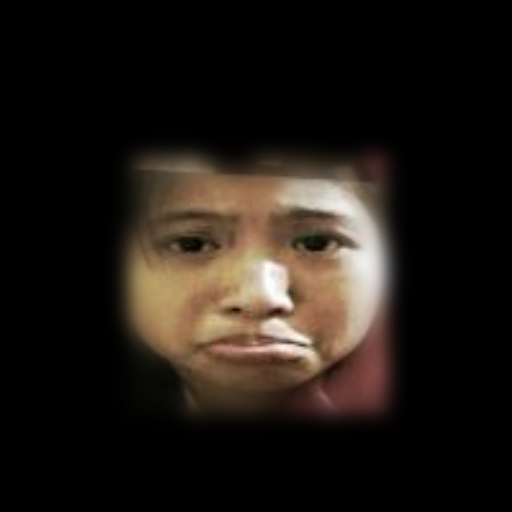

In [47]:
img

In [ ]:
prompt = ['Surprise',
'Fear',
'Disgust',
'Happiness',
'Sadness',
'Anger',
'Neutral']